<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/PreferredAI/tutorials/blob/master/recommender-systems/08_retrieval.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/PreferredAI/tutorials/blob/master/recommender-systems/08_retrieval.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Recommendation Retrieval 


A typical recommender system has two phases.  In the first phase (preference learning), which can be done offline, we learn the model from observations.  In the second phase (retrieval), upon the appearance of a user, we retrieve the top-ranked recommendations for that user.  This latter phase needs to be done online.  In this tutorial, we investigate ways to speed up the retrieval phase by avoiding an exhaustive search over all items.  The focus is on matrix factorization-based recommender systems.

## 1. Setup

In [1]:
!pip install --quiet cornac==1.15.4 torch>=0.4.1

In [2]:
import os
import sys
import time
import random
import pickle
from operator import itemgetter
from collections import defaultdict

import tqdm.auto as tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import cornac
from cornac.utils import cache
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.models import PMF, BPR, IBPR

print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")

SEED = 42
VERBOSE = True

System version: 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]
Cornac version: 1.15.4


## 2. Recommendation Retrieval is a Similarity Search Problem

The two phases of a matrix factorization-based recommender system are:
1. **Learning phase:** derive a $d$-dimensional latent vector $\mathbf{u}_i$ for each user $i$ and a $d$-dimensional latent vector $\mathbf{v}_j$ for each item $j$. The user-item relationship is modeled using the inner product kernel, i.e., the user preference of user $i$ for an item $j$ is given by:

$$\hat{r}_{i,j} = \mathbf{u}_i^T \mathbf{v}_j$$

2. **Retrieval phase:** given a user vector $\mathbf{u}_i$, construct a recommendation list of $K$ items with the highest preference scores. This step requires $\mathcal{O}(d \times M)$ preference score computations for $M$ number of items.


### Probabilistic Matrix Factorization

For the retrieval phase, the straightforward approach is to exhaustively compute the preference score for every item and maintain the top-$K$. Let us take a closer look through an example based on Probabilistic Matrix Factorization (PMF) [1].

For PMF, the objective is to learn for each user $i$ a vector $\mathbf{u}_i$ and each item $j$ a vector $\mathbf{v}_j$, such that the following error function is minimized over the set of observed ratings $\mathbf{R}$:
\begin{equation}
 \mathcal{L} = \sum_{r_{ui}\in \mathbf{R}}(r_{ui} - \mathbf{u}_i^T\mathbf{v}_j)^2 + \lambda \sum_{i = 1}^{N}||\mathbf{u}_i||^2 + \lambda\sum_{j = 1}^{M}||\mathbf{v}_j||^2, 
\end{equation}
where $\lambda$ is a regularization term.

We begin by running PMF on the Movielens 1M dataset.  

In [3]:
# Load the MovieLens 1M dataset
ml_1m = movielens.load_feedback(variant='1M')

Data from http://files.grouplens.org/datasets/movielens/ml-1m.zip
will be cached into /root/.cornac/ml-1m/ratings.dat


0.00B [00:00, ?B/s]

Unzipping ...
File cached!


In [4]:
# Instantiate an evaluation method
ratio_split = RatioSplit(
  data=ml_1m, test_size=0.4, rating_threshold=1.0, exclude_unknowns=False
)

# Instatiate a PMF recommender model
pmf = PMF(k=100, max_iter=100, learning_rate=0.01, seed=SEED, verbose=VERBOSE)

# Instantiate evaluation metrics.
rec_10 = cornac.metrics.Recall(k=10)
pre_10 = cornac.metrics.Precision(k=10)

# Instantiate and then run an experiment.
cornac.Experiment(
  eval_method=ratio_split, models=[pmf], metrics=[rec_10, pre_10]
).run()


TEST:
...
    | Precision@10 | Recall@10 | Train (s) | Test (s)
--- + ------------ + --------- + --------- + --------
PMF |       0.0794 |    0.0160 |  184.2373 |   7.8844



### Exhaustive Search

To retrieve the top-$K$ recommendation for a user $i$, we need to compute the inner product between the user's latent vector $\mathbf{u}_i$ and that of every item $\mathbf{v}_j$.  This is directly proportional to the number of items $M$ as well as the number of latent factors (dimensionality of the item vector) $d$, as we will see below.

**Observation #1: Retrieval time scales linearly with the number of items**

In [5]:
comp_time = []

# For each user vector, we compute the inner product score to each item vector
pmf_item_vect = pmf.V
pmf_user_vect = pmf.U

for incr_size in tqdm.trange(0, pmf_item_vect.shape[0], 10, disable=not VERBOSE):
  start_time = time.time()
  pred = np.matmul(pmf_item_vect[:incr_size, :], pmf_user_vect.T)
  end_time = time.time()
  comp_time.append((end_time - start_time) / pmf_user_vect.shape[0])

  0%|          | 0/365 [00:00<?, ?it/s]

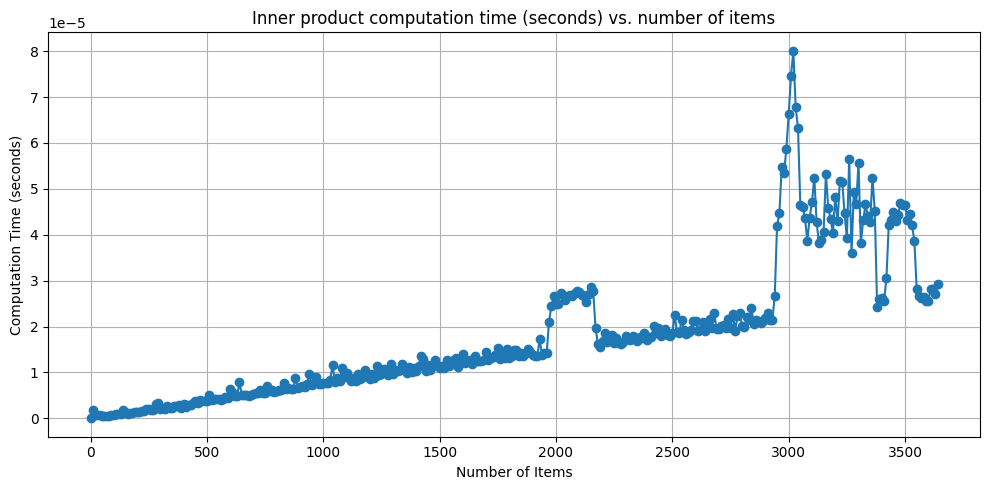

In [6]:
# plot the computation time as the number of items increases
plt.plot(range(0, pmf_item_vect.shape[0],10), comp_time, marker='o', 
         label='Computation_time')
plt.xlabel('Number of Items')
plt.ylabel('Computation Time (seconds)')
plt.title('Inner product computation time (seconds) vs. number of items')
plt.grid()
plt.gcf().set_size_inches(10, 5)
plt.tight_layout()
plt.show()

**Observation #2: Retrieval time scales linearly with the number of latent factors**

In [7]:
comp_time = []

for d in tqdm.trange(pmf.k, disable=not VERBOSE):
  start_time = time.time()
  pred = np.matmul(pmf_item_vect[:incr_size, :d], pmf_user_vect[:,:d].T)
  end_time = time.time()
  
  # average the computation time 
  comp_time.append((end_time - start_time) / pmf_user_vect.shape[0])

  0%|          | 0/100 [00:00<?, ?it/s]

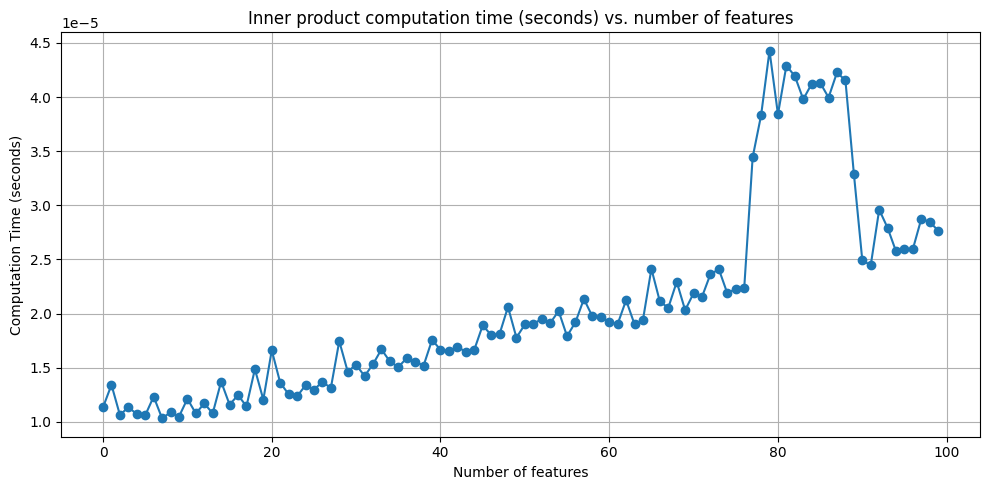

In [8]:
# plot the computation time as the number of dimension increases
plt.plot(range(pmf.k), comp_time, marker='o', label='Computation_time')
plt.title('Inner product computation time (seconds) vs. number of features')
plt.xlabel('Number of features')
plt.ylabel('Computation Time (seconds)')
plt.grid()
plt.gcf().set_size_inches(10, 5)
plt.tight_layout()
plt.show()

## 3. Scalable Recommendation Retrieval with Locality Sensitive Hashing
From the previous example, we can see that the cost of **exhaustive search** scales linearly to the number of items, i.e., $M$ and number of features, i.e., $d$. For modern real-world systems, the number of items could go up to the scale of millons.  Therefore, it would be fruitful to make the search more efficient.

### Locality Sensitive Hashing
One way to do so is to use Locality Sensitive Hashing (LSH), which is a probabilistic space-partitioning indexing technique. One important element of LSH is the hashing function $h(.)$, which maps a data point into a hash value. This hashing function is usually designed with the *locality-sensitive* property, stated as: *two similar data points are more likely to get the same hash values as compared to two distant data points.*

One of the most popular search protocols using LSH is hash table look-up.  In a nutshell, we first derive the hash codes for all items and construct a hash table that links a hash code to items of that code. When a user appears, we hash the user's latent vector into a hash code.  We then look up items of that hash code and compute the top-$K$ based on inner product *only among those items*, thus drastically reducing the number of items we need to consider.  To increase the search space, we can also use multiple hash tables, in which case we look up the multiple hash tables and compute the top-$K$ across the tables.

In [9]:
random.seed(SEED)

# Implementation of Locality Sensitive Hashing for Maximum Cosine Similarity Search
class LSHIndex:

  def __init__(self, hash_family, k, L):
    self.hash_family = hash_family
    self.k = k
    self.L = 0
    self.hash_tables = []
    self.resize(L)

  def resize(self, L):
    """ update the number of hash tables to be used """
    if L < self.L:
      self.hash_tables = self.hash_tables[:L]
    else:
      # initialise a new hash table for each hash function
      hash_funcs = [[self.hash_family.create_hash_func() for h in range(self.k)] 
                    for l in range(self.L, L)]
      self.hash_tables.extend([(g, defaultdict(lambda:[])) for g in hash_funcs])

  def hash(self, g, p):
    return self.hash_family.combine([h.hash(p) for h in g])

  def index(self, points):
    """ index the supplied points """
    self.points = points
    for g, table in self.hash_tables:
        for ix, p in enumerate(self.points):
            table[self.hash(g,p)].append(ix)
    # reset stats
    self.tot_touched = 0
    self.num_queries = 0

  def query(self, q, metric, max_results):
    """ find the max_results closest indexed points to q according to the supplied metric """
    candidates = set()
    for g, table in self.hash_tables:
        matches = table.get(self.hash(g,q), [])
        candidates.update(matches)
        
    # update stats
    self.tot_touched += len(candidates)
    self.num_queries += 1
    
    # rerank candidates
    candidates = [(ix, metric(q, self.points[ix])) for ix in candidates]
    candidates.sort(key = itemgetter(1))
    return candidates[:max_results]

  def get_avg_touched(self):
    """ mean number of candidates inspected per query """
    return self.tot_touched/self.num_queries


#################################################################################################
#--------------------------------- Cosine LSH Hash Family --------------------------------------#
#################################################################################################    
class CosineHashFamily:

  def __init__(self,d):
    self.d = d

  def create_hash_func(self):
    # each CosineHash is initialised with a random projection vector
    return CosineHash(self.rand_vec())

  def rand_vec(self):
    return [random.gauss(0,1) for i in range(self.d)]

  def combine(self, hashes):
    """combine by treating as a bitvector"""
    return sum(2**i if h > 0 else 0 for i,h in enumerate(hashes))
	
class CosineHash:

  def __init__(self, r):
    self.r = r

  def hash(self, vec):
    return self.sgn(dot(vec, self.r))

  def sgn(self,x):
    return int(x > 0)

#--- inner product ---
def dot(u,v):
	return np.dot(u, v) 

#-- cosine distance ---
def cosine_distance(u,v):
	return 1 - dot(u,v)/(dot(u,u)*dot(v,v))**0.5

In [10]:
# helper function to measure precision, recall, and touched values 
# of using LSH for top-k recommendation retrieval
# ------------------------------------------------------------------------
def evaluate_LSHTopK(test_data, item_vect, user_vect, lsh_index, sim_metric, topK):           

  lsh_prec = 0.0
  lsh_recall = 0.0
  
  #build index
  lsh_index.index(item_vect.tolist())
  
  for id in range(user_vect.shape[0]):      
    test_item_ids = list(test_data.csr_matrix.getrow(id).nonzero()[1])

    if len(test_item_ids) > 0:
      # top-k by LSH
      lsh_rec_list = list(map(itemgetter(0), lsh_index.query(user_vect[id, :], sim_metric, topK)))
      lsh_overlaps = list(set(lsh_rec_list).intersection(test_item_ids))

      lsh_prec   += len(lsh_overlaps) * 1.0/topK
      lsh_recall += len(lsh_overlaps) * 1.0/len(test_item_ids)

  touched = lsh_index.get_avg_touched() * 1.0/item_vect.shape[0]
  return lsh_prec/user_vect.shape[0], lsh_recall/user_vect.shape[0], touched

### Issue with Using Locality Sensitive Hashing for Recommendation Retrieval

Recommendation retrieval, which relies on inner product computation is not directly compatible with Locality Sensitive Hashing, which is designed for nearest neighbor search or maximum cosine similarity search. This might lead to the significant degeneration of recommendation accuracy after indexing [2].

In the following, we introduce two approaches to this issue:

1.   Vector Augmentation
2.   Indexable Representation


### Solution I: Vector Augmentation
In this solution, we first apply the vector transformation for both user and item vectors, as introduced in the paper [3]. 

For each item vector $\mathbf{v}_j$:
\begin{equation}
\mathbf{\tilde{v}}_j = [\mathbf{v}_j; \sqrt{\phi^2 - ||\mathbf{v}_j||^2}]  \hspace{1cm}(\mathrm{where}\ \phi = \max\{||\mathbf{v}_j||\})
\end{equation}

For each user vector $\mathbf{u}_i$:
\begin{equation}
\mathbf{\tilde{u}}_i = [\mathbf{u}_i; 0]
\end{equation}

We have the following observation:

\begin{equation}
\frac{\mathbf{\tilde{u}}_i^T\mathbf{\tilde{v}}_j}{||\mathbf{\tilde{u}}_i||\times ||\mathbf{\tilde{v}}_j||} = \frac{\mathbf{\tilde{u}}_i^T\mathbf{\tilde{v}}_j}{\phi ||\mathbf{\tilde{u}}_i||}
\end{equation}

i.e., 

\begin{equation}
\arg\max_{1\leq j\leq M}{\mathbf{{u}}_i^T\mathbf{{v}}_j} = \arg\max_{1\leq j\leq M}\frac{\mathbf{\tilde{u}}_i^T\mathbf{\tilde{v}}_j}{||\mathbf{\tilde{u}}_i||\times ||\mathbf{\tilde{v}}_j||}
\end{equation}


With this vector augmentation, we effectively convert a Maximum Inner Product Search (MIPS) problem to a Maximum Cosine Similarity Search (MCCS), which can be solved with LSH.  Hypothetically, this will make the user and item latent vectors more compatible with LSH.

In [11]:
#apply vector augmentation
M = np.linalg.norm(pmf_item_vect, axis=1) # compute item vector norms
max_norm = max(M) # max item norm

xbox_item_vect = np.concatenate(
  (pmf_item_vect, np.sqrt(max_norm**2 - pow(M, 2)).reshape(pmf_item_vect.shape[0], -1)), 
  axis=1
)
xbox_user_vect = np.concatenate(
  (pmf_user_vect, np.zeros((pmf_user_vect.shape[0], 1))), 
  axis=1
)

#### Effectiveness of Vector Augmentation

In this experiment, we build LSH index on the output of PMF algorithm and compare the latent vectors before and after vector augmentation for LSH recommendation retrieval.

Since the augmented user and item vectors are in $(d+1)-$dimensional space, for comparison purpose we append 0s to the original non-augmented user and item vectors (to make them the same length), i.e.,

\begin{equation}
\mathbf{\tilde{v}}_j = [\mathbf{v}_j; 0]
\end{equation}

\begin{equation}
\mathbf{\tilde{u}}_i = [\mathbf{u}_i; 0]
\end{equation}

With this non-augmented "transformation", we have no change to the original inner product:

\begin{equation}
\mathbf{\tilde{u}}_i^T\mathbf{\tilde{v}}_j = \mathbf{{u}}_i^T\mathbf{{v}}_j
\end{equation}

In [12]:
padded_user_vect = np.concatenate((pmf_user_vect, np.zeros((pmf_user_vect.shape[0], 1))), axis=1)
padded_item_vect = np.concatenate((pmf_item_vect, np.zeros((pmf_item_vect.shape[0], 1))), axis=1)


Specifically, we report three evaluation metrics as follows:

1. lsh_prec@10 = $\text{precision@10 of LSH Indexing}$ 
&nbsp;
&nbsp;
&nbsp;  
&nbsp;
2. lsh_rec@10    = $\text{recall@10 of LSH Indexing}$
&nbsp;
&nbsp;
&nbsp;  
&nbsp;
3. touched = $\frac{\text{Average number of investigated items by LSH}}{\text{Total number of items}}$


In [13]:
topK = 10 # @param - top-K value 
b_vals = [4, 8] # @param - number of hash function
L_vals = [10, 20] # @param - number of hashtables

test_data  = ratio_split.test_set # testing data

print('#table \t#bit \t ?Augmented \t lsh_prec@{0} \t lsh_recall@{0} \t touched'.format(topK))
for nt in L_vals:
  for b in b_vals: 
    #init lsh index:
    #------ hash-family: the LSH scheme/family 
    #------ k          : number of hash functions
    #------ L          : number of hash tables
    lsh_index = LSHIndex(hash_family = CosineHashFamily(padded_item_vect.shape[1]), k = b, L=nt)
    
    #performance without employing vector augmentation
    print('---------------------------------------------------------------------------------')
    prec_1, recall_1, touched_1 = evaluate_LSHTopK(
      test_data, padded_item_vect, -padded_user_vect[:1000], lsh_index, dot, topK
    )
    print("{}\t{}\t{}\t{:.4f}\t{:.4f}\t{:.4f}".format(nt, b, 'No', prec_1, recall_1, touched_1)) 
    
    #performance with vector augmentation
    prec_2, recall_2, touched_2 = evaluate_LSHTopK(
      test_data, xbox_item_vect, -xbox_user_vect[:1000], lsh_index, dot, topK
    )
    print("{}\t{}\t{}\t{:.4f}\t{:.4f}\t{:.4f}".format(nt, b, 'Yes', prec_2, recall_2, touched_2)) 

#table 	#bit 	 ?Augmented 	 lsh_prec@10 	 lsh_recall@10 	 touched
---------------------------------------------------------------------------------
10	4	No	0.1135	0.0106	0.4487
10	4	Yes	0.1204	0.0110	0.6657
---------------------------------------------------------------------------------
10	8	No	0.0701	0.0057	0.0400
10	8	Yes	0.0797	0.0067	0.0703
---------------------------------------------------------------------------------
20	4	No	0.1183	0.0112	0.6837
20	4	Yes	0.1243	0.0119	0.8697
---------------------------------------------------------------------------------
20	8	No	0.0774	0.0062	0.0750
20	8	Yes	0.0845	0.0073	0.1337


We observe from the results above that with vector augmentation, we can achieve higher recommendation accuracy after using Locality Sensitive Hashing.

What is the effect of increasing the number of bits, or the number of hash tables? Why?


### Solution II: Indexable Representation Learning
Another solution is "Indexable representation", which refers to recommendation algorithms whose user/item vectors are immediately sublinearly searchable. In this tutorial, we are going to experiment with one such model, namely Indexable Bayesian Personalized Ranking or IBPR [5] for short. IBPR is an extension of the popular framework for implicit feedback: Bayesian Personalized Ranking (BPR) [4].



#### Bayesian Personalized Ranking - BPR

Let us see the performance of BPR with exhaustive search. 

In [14]:
rec_bpr = BPR(k=20, max_iter=100, learning_rate=0.001, seed=SEED, verbose=VERBOSE)

cornac.Experiment(
  eval_method=ratio_split, models=[rec_bpr], metrics=[rec_10, pre_10],
).run()

  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!

TEST:
...
    | Precision@10 | Recall@10 | Train (s) | Test (s)
--- + ------------ + --------- + --------- + --------
BPR |       0.1828 |    0.0444 |   14.7013 |   6.2401



We now measure the performance of BPR after LSH indexing. 

In [15]:
bpr_user_vect  = rec_bpr.u_factors
bpr_item_vect  = rec_bpr.i_factors

# apply Xbox transformation
M = np.linalg.norm(bpr_item_vect, axis=1) # compute item vector norms
max_norm = max(M) # max item norm

xbox_bpr_item_vect = np.concatenate(
  (bpr_item_vect, np.sqrt(max_norm**2 - pow(M, 2)).reshape(bpr_item_vect.shape[0], -1)), 
  axis=1
)
xbox_bpr_user_vect = np.concatenate(
  (bpr_user_vect, np.zeros((bpr_user_vect.shape[0], 1))), 
  axis = 1
)

In [16]:
topK = 10 # @param
b_vals = [4, 8] # @param
L_vals = [10, 20] # @param

test_data  = ratio_split.test_set # testing data

print('#table\t #bit \t model \t lsh_prec@{0} \t lsh_recall@{0} \t touched'.format(topK))
for nt in L_vals:
  print('------------------------------------------------------------------------------')
  for b in b_vals: 
    # lsh index:
    #------ hash-family: the LSH scheme/family 
    #------ k          : number of hash functions
    #------ L          : number of hash tables
    lsh_index = LSHIndex(hash_family = CosineHashFamily(xbox_bpr_item_vect.shape[1]), k = b, L = nt)
    
    lsh_bpr_prec, lsh_bpr_recall, touched_bpr = evaluate_LSHTopK(
      test_data, xbox_bpr_item_vect, -xbox_bpr_user_vect[:1000, :], lsh_index, dot, topK
    )
    print("{}\t{}\t{}\t{:.4f}\t{:.4f}\t{:.4f}".format(
      nt, b, 'BPR', lsh_bpr_prec, lsh_bpr_recall, touched_bpr)
    )

#table	 #bit 	 model 	 lsh_prec@10 	 lsh_recall@10 	 touched
------------------------------------------------------------------------------
10	4	BPR	0.0464	0.0030	0.4808
10	8	BPR	0.0341	0.0021	0.0474
------------------------------------------------------------------------------
20	4	BPR	0.0506	0.0032	0.7054
20	8	BPR	0.0388	0.0024	0.0940


The results above show that in relative terms, the performance degenerates for both precision and recall.


#### Indexable Bayesian Personalized Ranking - IBPR

We will now test the effectiveness of indexable model IBPR. In this experiment, we train IBPR with the same data we use for BPR and measure the performance after LSH indexing.

In [17]:
rec_ibpr = IBPR(k=20, max_iter=15, learning_rate=0.001, verbose=VERBOSE)

cornac.Experiment(
  eval_method=ratio_split, models =[rec_ibpr], metrics=[rec_10, pre_10]
).run()

Epoch 1/15:   0%|          | 0/6002 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/6002 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/6002 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/6002 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/6002 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/6002 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/6002 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/6002 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/6002 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/6002 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/6002 [00:00<?, ?it/s]

Epoch 12/15:   0%|          | 0/6002 [00:00<?, ?it/s]

Epoch 13/15:   0%|          | 0/6002 [00:00<?, ?it/s]

Epoch 14/15:   0%|          | 0/6002 [00:00<?, ?it/s]

Epoch 15/15:   0%|          | 0/6002 [00:00<?, ?it/s]


TEST:
...
     | Precision@10 | Recall@10 | Train (s) | Test (s)
---- + ------------ + --------- + --------- + --------
IBPR |       0.1670 |    0.0389 |  597.7660 |   6.6744



In [18]:
ibpr_user_vect = rec_ibpr.U
ibpr_item_vect = rec_ibpr.V

In [19]:
topK = 10 # @param
b_vals = [4, 8] # @param 
L_vals = [10, 20] # @param

test_data = ratio_split.test_set # testing data

print('#table\t #bit \t model \t lsh_prec@{0} \t lsh_recall@{0} \t touched'.format(topK))
for nt in L_vals:
  print('------------------------------------------------------------------------------')
  for b in b_vals: 
    # lsh index:
    #------ hash-family: the LSH scheme/family 
    #------ k          : number of hash functions
    #------ L          : number of hash tables
    lsh_index = LSHIndex(hash_family = CosineHashFamily(ibpr_item_vect.shape[1]), k = b, L = nt)
    
    lsh_ibpr_prec, lsh_ibpr_recall, touched_ibpr = evaluate_LSHTopK(
      test_data, ibpr_item_vect, -ibpr_user_vect[:1000,:], lsh_index, dot, topK
    )
    print("{}\t{}\t{}\t{:.4f}\t{:.4f}\t{:.4f}".format(
      nt, b, 'IBPR', lsh_ibpr_prec, lsh_ibpr_recall, touched_ibpr)
    ) 

#table	 #bit 	 model 	 lsh_prec@10 	 lsh_recall@10 	 touched
------------------------------------------------------------------------------
10	4	IBPR	0.0822	0.0056	0.6366
10	8	IBPR	0.0348	0.0022	0.4623
------------------------------------------------------------------------------
20	4	IBPR	0.0825	0.0060	0.7433
20	8	IBPR	0.0373	0.0022	0.5283


We observe that the performance after LSH of IBPR (without vector augmentation) could be better than that of BPR (with vector augmentation), which may be attributed to having representations more compatible with indexing.  As a result, we could speed up top-$K$ recommendation retrieval, while better preserving the accuracy. 

## References

1. Mnih, Andriy, and Russ R. Salakhutdinov. "Probabilistic matrix factorization." Advances in neural information processing systems. 2008.

2. Stochastically Robust Personalized Ranking for LSH Recommendation Retrieval, Dung D. Le and Hady W. Lauw
AAAI Conference on Artificial Intelligence (AAAI-20)
 
3. Bachrach, Yoram, et al. "Speeding up the xbox recommender system using a euclidean transformation for inner-product spaces." Proceedings of the 8th ACM Conference on Recommender systems. 2014.

4. Rendle, Steffen, et al. "BPR: Bayesian personalized ranking from implicit feedback." arXiv preprint arXiv:1205.2618 (2012).

5. Le, Dung D., and Hady W. Lauw. "Indexable Bayesian personalized ranking for efficient top-k recommendation." Proceedings of the 2017 ACM on Conference on Information and Knowledge Management. 2017.

6.   Cornac - A Comparative Framework for Multimodal Recommender Systems (https://cornac.preferred.ai/)
